In [1]:
from astropy.stats import sigma_clipped_stats
import astropy.io.fits as fits
import glob
import matplotlib.pyplot as plt
import numpy as np

In [144]:
def getimagesbytemp(images, temp):
    result = []
    for n in glob.glob(images):
        
        f = fits.open (n)
        temperature = float(f['SCI'].header['CCDATEMP'])
        
        if (abs(temperature-temp) < 0.2):
            result.append (f)
        else:
            f.close()
    return (result)
        
def getcombinedimage(fitsfiles):
    exptime=0
    gain=0
    newdata = np.zeros_like(fitsfiles[0]['SCI'].data)
    combstack = np.empty( (len(fitsfiles), newdata.shape[0], newdata.shape[1]))
    for idx, fitsobj in enumerate(fitsfiles):
        combstack[idx] = fitsobj['SCI'].data
        exptime = float(fitsobj['SCI'].header['EXPTIME'])
        gain = float(fitsobj['SCI'].header['GAIN'])

        fitsobj.close()
        
    newdata = np.average (combstack, axis=0)
    ovdata = newdata[-30:-1,100:-100]
    (ovmean,ovmedian,ovstd) = sigma_clipped_stats(ovdata.flatten(),)
    print (ovmean,ovstd, exptime)
    newdata -= ovmean
    newdata = newdata / exptime * gain
    return newdata[1:-50,:-600:-50].flatten()
                         
    


In [145]:
fits_m10 = getimagesbytemp('/home/dharbeck/lco/sq35_dark_current/*.fz',-10)
dark_m10 = getcombinedimage(fits_m10)
fits_m5 = getimagesbytemp('/home/dharbeck/lco/sq35_dark_current/*.fz',-5)
dark_m5 = getcombinedimage(fits_m5)
fits_0 = getimagesbytemp('/home/dharbeck/lco/sq35_dark_current/*.fz',0)
dark_0 = getcombinedimage(fits_0)
fits_p5 = getimagesbytemp('/home/dharbeck/lco/sq35_dark_current/*.fz',5)
dark_p5 = getcombinedimage(fits_p5)


488.51449108794344 1.463130733028752 299.997
488.52900846568394 1.479394830595113 299.997
488.4228528119524 1.4897030363750583 299.997
488.2939117630342 1.501097413924122 299.997


In [146]:
fits_p10 = getimagesbytemp('/home/dharbeck/lco/sq35_dark_current/*.fz',10)
dark_p10 = getcombinedimage(fits_p10)

488.2281943612565 1.5044775312446708 299.997


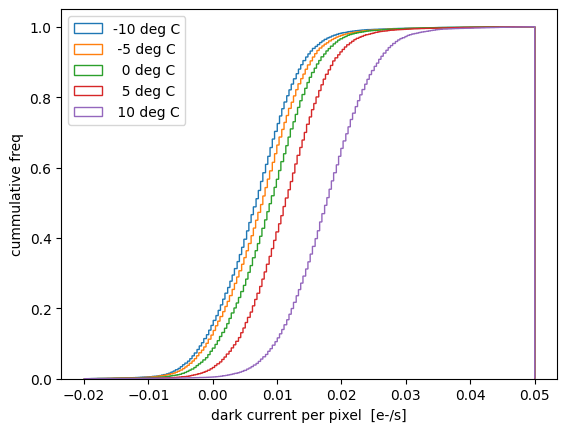

In [147]:

def histdata(data,label):
    myslice = data
    plt.hist (myslice.flatten(), range=(-0.02,0.05), density=True,bins=1000, cumulative=True,label=label,histtype='step')

plt.figure()
histdata (dark_m10, '-10 deg C')
histdata (dark_m5,  ' -5 deg C')
histdata (dark_0,  '  0 deg C')
histdata (dark_p5, '  5 deg C')
histdata (dark_p10, ' 10 deg C')

plt.legend()
plt.xlabel ("dark current per pixel  [e-/s]")
plt.ylabel ("cummulative freq")

plt.show()



/tmp/ipykernel_18718/2819192077.py:10: RuntimeWarning: invalid value encountered in log
  d_array = np.log(d_array)


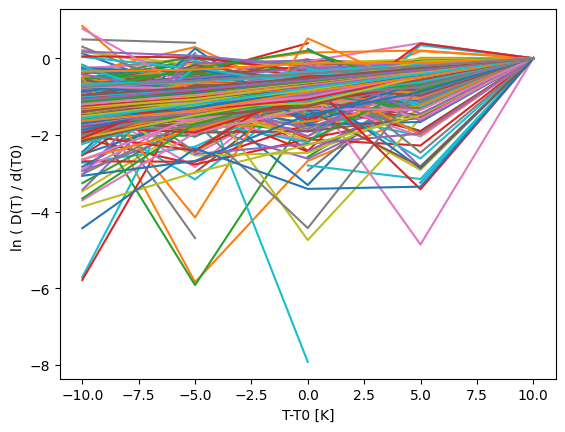

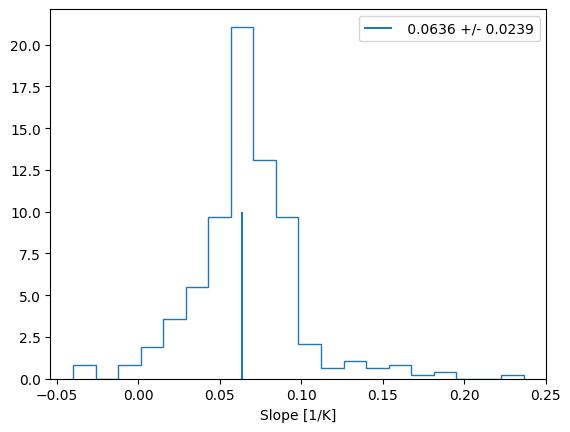

In [150]:
# Try by hot pixel scaling
intensityidx = np.argsort(dark_p10) 

plt.figure()
slopes = []
for idx in intensityidx[-400:-2]:
    t_array = np.asarray([-10,-5,0,5, 10]) -0
    d_array = np.asarray([dark_m10[idx],dark_m5[idx],dark_0[idx],dark_p5[idx],dark_p10[idx]])
    d_array = d_array / d_array[-1]
    d_array = np.log(d_array)
    plt.plot ( t_array, d_array)
    pf = np.polyfit (t_array,d_array,1)
    slopes.append (pf[0])

plt.xlabel ("T-T0 [K]")
plt.ylabel ("ln ( D(T) / d(T0) ")
plt.show()

plt.figure()
(mean,med,std) = sigma_clipped_stats(slopes)
plt.hist(slopes,histtype='step',  bins=20, density=True)
plt.vlines([mean,],0,10, label=f"{mean: 5.4f} +/- {std:5.4f}" )
plt.legend()
plt.xlabel ("Slope [1/K]")
plt.show()

